In [1]:
import random
import torch
import pickle
import os

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '6'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_steps = 1000
seed = 0
hidden_dims = {'F'}
lookback = 1
train_eps = 200

random.seed(seed)
torch.manual_seed(seed)

In [4]:
expert_env = AntMazePCH(num_steps=num_steps, hidden_dims=set(), seed=seed)

In [5]:
env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)

In [6]:
# to save time; conceptually the same
small_steps = lookback + 1
small_env = AntMazePCH(num_steps=small_steps, hidden_dims=hidden_dims, seed=seed)
G = parse_graph(small_env.get_graph)
X_small = {f'X{t}' for t in range(small_steps)}
Y = f'Y{small_steps}'

# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [7]:
Z_sets = find_sequential_pi_backdoor(G, X_small, Y, obs_prefix)

base_step = small_steps - 1
base_Z_set = Z_sets[f'X{base_step}']

for i in range(base_step + 1, num_steps):
    updated_base_Z_set = set()
    for v in base_Z_set:
        updated_base_Z_set.add(f'{v[0]}{int(v[1:]) + i - lookback}')

    Z_sets[f'X{i}'] = updated_base_Z_set

In [8]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

In [9]:
# load expert
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt'
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

expert = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

expert.load_state_dict(checkpoint['state_dict'])
expert.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

def make_ft_policies_with_F(model, slots, Z_trim, device, num_steps, extra_vars):
    policies = {}
    for t in range(num_steps):
        def pi_t(obs, t=t):
            state = build_state_feature(obs, t, Z_trim, slots, device, extra_vars=extra_vars)

            with torch.no_grad():
                action = model(state).squeeze(0).cpu().numpy().astype(np.float32)

            return action
        
        policies[f'X{t}'] = pi_t

    return policies

expert_policies = make_ft_policies_with_F(
    expert,
    slots=slots,
    Z_trim=Z_trim,
    device=device,
    num_steps=num_steps,
    extra_vars={'F'}
)

In [10]:
records = collect_imitator_trajectories(
    expert_env,
    expert_policies,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed,
    hidden_dims=hidden_dims,
    show_progress=True
)

Starting episode 1/200...
  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/200...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/200...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/200...
  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/200...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/200...
  Episode 6 ended at step 279 (terminated: True, truncated: False).
Starting episode 7/200...
  Episode 7 ended at step 595 (terminated: True, truncated: False).
Starting episode 8/200...
  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/200...
  Episode 9 ended at step 343 (terminated: True, truncated: False).
Starting episode 10/200...
  Episode 10 ended at step 392 (terminated: True, truncated: False).
Starting episode 11/200...
  Episode 11 ended at ste

In [11]:
# with open('/home/et2842/causal/expert_traj.pkl', 'wb') as f:
#     pickle.dump(records, f)

# print(f'saved {len(records)} trajectories')

In [12]:
# with open('/home/et2842/causal/expert_traj.pkl', 'rb') as f:
#     records = pickle.load(f)

# print(f'loaded {len(records)} trajectories')

In [13]:
hidden_size = 256
lr = 3e-4
batch_size = 2048
patience = 15
num_blocks = 4
epochs = 100
dropout = 0.0

dims = {
    'P': 3,
    'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    # 'F': 2,
    'W': 1,
    'X': 8
}

In [14]:
causal_model, causal_slots, causal_Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

causal_policy = shared_policy_fn_long_horizon(causal_model, causal_slots, causal_Z_trim, continuous=True, device=device)
causal_policies = make_shared_policy_dict(causal_policy)

[LongHorizon] Epoch 1: train loss = 0.104070, val loss = 0.044136.
[LongHorizon] Epoch 2: train loss = 0.033751, val loss = 0.027892.
[LongHorizon] Epoch 3: train loss = 0.023805, val loss = 0.021793.
[LongHorizon] Epoch 4: train loss = 0.018988, val loss = 0.017957.
[LongHorizon] Epoch 5: train loss = 0.015841, val loss = 0.015729.
[LongHorizon] Epoch 6: train loss = 0.013825, val loss = 0.014328.
[LongHorizon] Epoch 7: train loss = 0.012297, val loss = 0.012823.
[LongHorizon] Epoch 8: train loss = 0.011151, val loss = 0.011894.
[LongHorizon] Epoch 9: train loss = 0.010246, val loss = 0.011210.
[LongHorizon] Epoch 10: train loss = 0.009505, val loss = 0.010491.
[LongHorizon] Epoch 11: train loss = 0.008906, val loss = 0.010097.
[LongHorizon] Epoch 12: train loss = 0.008440, val loss = 0.009594.
[LongHorizon] Epoch 13: train loss = 0.007998, val loss = 0.009330.
[LongHorizon] Epoch 14: train loss = 0.007583, val loss = 0.008854.
[LongHorizon] Epoch 15: train loss = 0.007235, val loss =

In [15]:
naive_model, naive_slots, naive_Z_trim = train_single_policy_long_horizon(
    records,
    naive_Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

naive_policy = shared_policy_fn_long_horizon(naive_model, naive_slots, naive_Z_trim, continuous=True, device=device)
naive_policies = make_shared_policy_dict(naive_policy)

[LongHorizon] Epoch 1: train loss = 0.104284, val loss = 0.044491.
[LongHorizon] Epoch 2: train loss = 0.033944, val loss = 0.027951.
[LongHorizon] Epoch 3: train loss = 0.023910, val loss = 0.022072.
[LongHorizon] Epoch 4: train loss = 0.019078, val loss = 0.017978.
[LongHorizon] Epoch 5: train loss = 0.015963, val loss = 0.015761.
[LongHorizon] Epoch 6: train loss = 0.013965, val loss = 0.014739.
[LongHorizon] Epoch 7: train loss = 0.012467, val loss = 0.012775.
[LongHorizon] Epoch 8: train loss = 0.011223, val loss = 0.011989.
[LongHorizon] Epoch 9: train loss = 0.010363, val loss = 0.011216.
[LongHorizon] Epoch 10: train loss = 0.009591, val loss = 0.010634.
[LongHorizon] Epoch 11: train loss = 0.009001, val loss = 0.010186.
[LongHorizon] Epoch 12: train loss = 0.008529, val loss = 0.009666.
[LongHorizon] Epoch 13: train loss = 0.008060, val loss = 0.009400.
[LongHorizon] Epoch 14: train loss = 0.007678, val loss = 0.009007.
[LongHorizon] Epoch 15: train loss = 0.007296, val loss =

Starting episode 1/200...
  Episode 1 ended at step 472 (terminated: True, truncated: False).
Starting episode 2/200...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/200...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/200...
  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/200...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/200...
  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/200...
  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/200...
  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/200...
  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/200...
  Episode 10 ended at step 472 (terminated: True, truncated: False).
Starting episode 11/200...
  Episode 11 ended at s

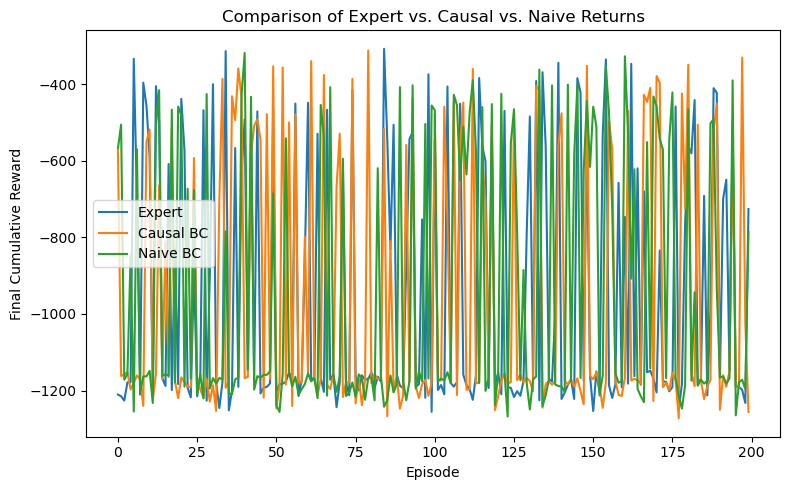

In [16]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

causal_records = collect_imitator_trajectories(
    env,
    causal_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_episode_rewards = defaultdict(float)
for rec in causal_records:
    ep = rec['episode']
    causal_episode_rewards[ep] += float(rec['reward'])

causal_rewards = [causal_episode_rewards[e] for e in range(num_eps)]

naive_records = collect_imitator_trajectories(
    env,
    naive_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_episode_rewards = defaultdict(float)
for rec in naive_records:
    ep = rec['episode']
    naive_episode_rewards[ep] += float(rec['reward'])

naive_rewards = [naive_episode_rewards[e] for e in range(num_eps)]

plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
plt.plot(causal_rewards, label='Causal BC')
plt.plot(naive_rewards, label='Naive BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
sum(expert_rewards)/num_eps, sum(causal_rewards)/num_eps, sum(naive_rewards)/num_eps

(-945.711368717184, -964.1712854484664, -944.5896266543812)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

In [19]:
i = 0

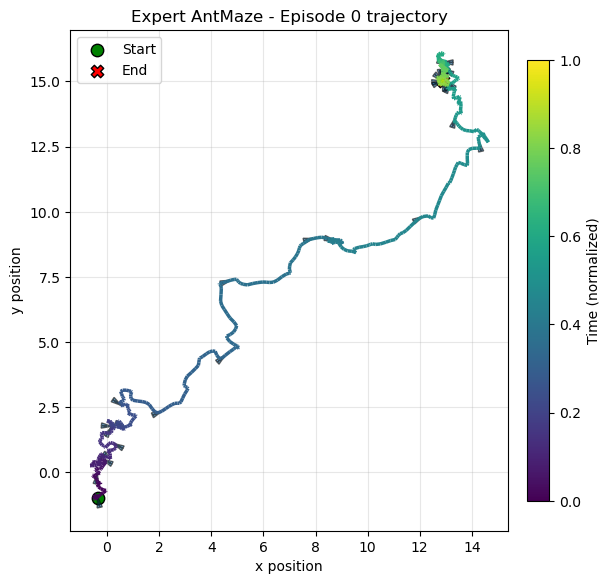

In [20]:
fig, ax = plot_ant_trajectory_xy(records, episode_id=i % num_eps, title_prefix='Expert AntMaze')
plt.show()
i += 1

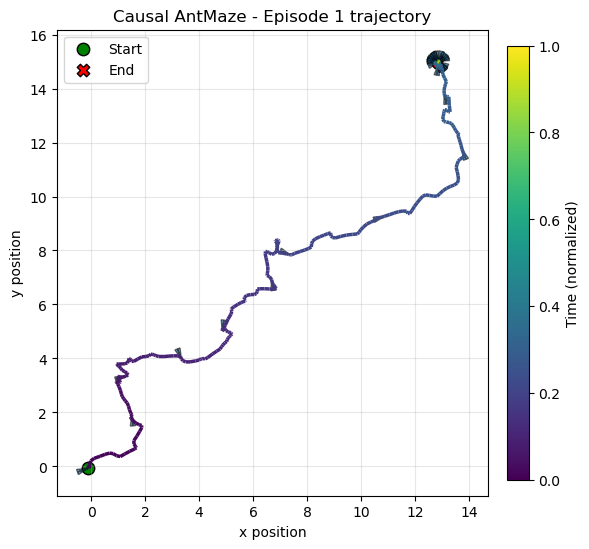

In [21]:
fig, ax = plot_ant_trajectory_xy(causal_records, episode_id=i % num_eps, title_prefix='Causal AntMaze')
plt.show()
i += 1

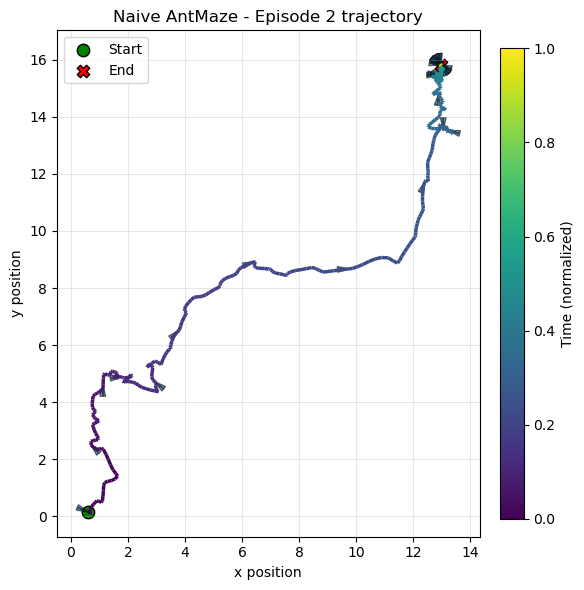

In [22]:
fig, ax = plot_ant_trajectory_xy(naive_records, episode_id=i % num_eps, title_prefix='Naive AntMaze')
plt.show()
i += 1

# samples: expert=159141, causal=162394, naive=159548
Expert: corr(W, ||a||) = 0.004 (p=0.11)
Causal BC: corr(W, ||a||) = -0.008 (p=0.00169)
Naive BC: corr(W, ||a||) = -0.004 (p=0.0815)


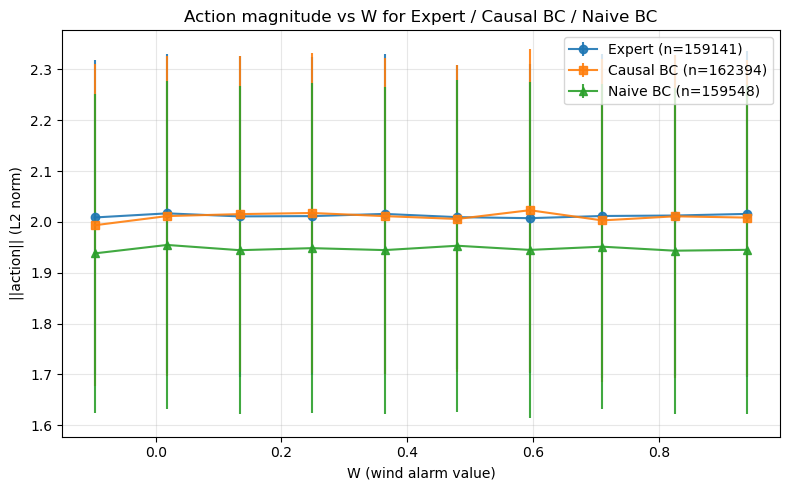

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr  # if not installed, comment this out or install scipy

def extract_w_and_actions(trajs):
    """
    trajs: list of dicts from collect_imitator_trajectories(...)
    Returns:
        ws:  (N,) array of scalar W values
        acts: (N, action_dim) array of actions
    """
    ws = []
    acts = []

    for r in trajs:
        obs = r['obs']
        # Each obs['W'] and obs['X'] is a *history* list; last entry is current
        if 'W' not in obs or 'X' not in obs:
            continue
        if len(obs['W']) == 0 or len(obs['X']) == 0:
            continue

        w_t = obs['W'][-1]        # shape (1,)
        a_t = obs['X'][-1]        # shape (action_dim,)

        ws.append(float(w_t[0]))
        acts.append(np.asarray(a_t, dtype=np.float64))

    if len(ws) == 0:
        return np.array([]), np.empty((0,))

    return np.array(ws, dtype=np.float64), np.stack(acts, axis=0)

# Extract (W, actions) for each policy
w_exp, a_exp = extract_w_and_actions(records)
w_cau, a_cau = extract_w_and_actions(causal_records)
w_nav, a_nav = extract_w_and_actions(naive_records)

# Compute action norms
n_exp = np.linalg.norm(a_exp, axis=1) if a_exp.size > 0 else np.array([])
n_cau = np.linalg.norm(a_cau, axis=1) if a_cau.size > 0 else np.array([])
n_nav = np.linalg.norm(a_nav, axis=1) if a_nav.size > 0 else np.array([])

print(f"# samples: expert={len(n_exp)}, causal={len(n_cau)}, naive={len(n_nav)}")

# Optional: print simple correlations W vs ||action||
def safe_corr(x, y, name):
    if len(x) > 2 and len(x) == len(y):
        r, p = pearsonr(x, y)
        print(f"{name}: corr(W, ||a||) = {r:.3f} (p={p:.3g})")
    else:
        print(f"{name}: not enough data for correlation")

safe_corr(w_exp, n_exp,  "Expert")
safe_corr(w_cau, n_cau,  "Causal BC")
safe_corr(w_nav, n_nav,  "Naive BC")

# Bin W and compute mean action norm per bin
def binned_stats(ws, norms, bins):
    """
    Returns bin_centers, mean_norms, std_norms, counts
    """
    idx = np.digitize(ws, bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    mean_norms = np.zeros(len(bin_centers))
    std_norms  = np.zeros(len(bin_centers))
    counts     = np.zeros(len(bin_centers), dtype=int)

    for b in range(1, len(bins)):  # bins are 1..len(bins)-1 from digitize
        mask = (idx == b)
        if np.any(mask):
            vals = norms[mask]
            mean_norms[b-1] = vals.mean()
            std_norms[b-1]  = vals.std()
            counts[b-1]     = mask.sum()

    return bin_centers, mean_norms, std_norms, counts

# Build global bins from all W values
all_w = np.concatenate([w_exp, w_cau, w_nav]) if len(w_exp)+len(w_cau)+len(w_nav) > 0 else np.array([])
if all_w.size == 0:
    print("No W data found in trajectories.")
else:
    n_bins = 10
    w_min, w_max = all_w.min(), all_w.max()
    if w_min == w_max:
        # Degenerate case: all W the same
        bins = np.linspace(w_min - 1e-3, w_max + 1e-3, n_bins + 1)
    else:
        bins = np.linspace(w_min, w_max, n_bins + 1)

    fig, ax = plt.subplots(figsize=(8,5))

    if len(w_exp) > 0:
        c_exp, m_exp, s_exp, cts_exp = binned_stats(w_exp, n_exp, bins)
        ax.errorbar(c_exp, m_exp, yerr=s_exp, fmt='-o', label=f'Expert (n={len(n_exp)})', alpha=0.9)

    if len(w_cau) > 0:
        c_cau, m_cau, s_cau, cts_cau = binned_stats(w_cau, n_cau, bins)
        ax.errorbar(c_cau, m_cau, yerr=s_cau, fmt='-s', label=f'Causal BC (n={len(n_cau)})', alpha=0.9)

    if len(w_nav) > 0:
        c_nav, m_nav, s_nav, cts_nav = binned_stats(w_nav, n_nav, bins)
        ax.errorbar(c_nav, m_nav, yerr=s_nav, fmt='-^', label=f'Naive BC (n={len(n_nav)})', alpha=0.9)

    ax.set_xlabel('W (wind alarm value)')
    ax.set_ylabel('||action|| (L2 norm)')
    ax.set_title('Action magnitude vs W for Expert / Causal BC / Naive BC')
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


Starting episode 1/20...
  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/20...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/20...
  Episode 3 ended at step 317 (terminated: True, truncated: False).
Starting episode 4/20...
  Episode 4 ended at step 454 (terminated: True, truncated: False).
Starting episode 5/20...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/20...
  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/20...
  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/20...
  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/20...
  Episode 9 ended at step 553 (terminated: True, truncated: False).
Starting episode 10/20...
  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/20...
  Episode 11 ended at step 546 (ter

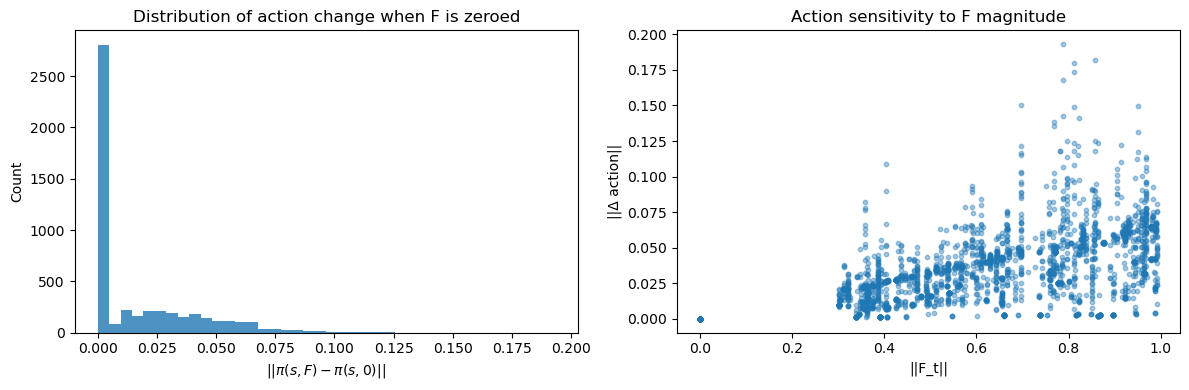

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# 1) Collect fresh expert trajectories with FULL observations (including F)
analysis_seed = 123
num_analysis_eps = 20

env_full = AntMazePCH(num_steps=num_steps, hidden_dims=set(), seed=analysis_seed)

expert_policies_full = make_ft_policies_with_F(
    expert,
    slots=slots,
    Z_trim=Z_trim,
    device=device,
    num_steps=num_steps,
    extra_vars={'F'}
)

full_records = collect_imitator_trajectories(
    env_full,
    expert_policies_full,
    num_episodes=num_analysis_eps,
    max_steps=num_steps,
    seed=analysis_seed,
    hidden_dims=None,
    show_progress=True
)

print(f"Collected {len(full_records)} expert transitions for F-sensitivity analysis.")

# 2) For a subset of timesteps, compare actions with F vs F-zeroed

# We know input_dim includes F at the end because we appended F after BC pretraining.
input_dim = expert.hidden.in_features
F_dim = 2  # you used extra_dim = 2 for F
base_dim = input_dim - F_dim

all_deltas = []
all_F_norms = []
all_action_norms = []

# Optional: limit number of samples to keep computation light
max_samples = 5000
sample_count = 0

expert.eval()

with torch.no_grad():
    for r in full_records:
        if sample_count >= max_samples:
            break

        t = r['step']
        obs = r['obs']   # contains histories; F should be in here as obs['F']

        # Skip very early steps if you want to avoid edge effects from lookback
        if t < 1:
            continue

        # Build state with F as usual
        state_full = build_state_feature(
            obs,
            t,
            Z_trim,
            slots,
            device,
            extra_vars={'F'}
        )  # shape (1, input_dim)

        if state_full.shape[1] != input_dim:
            print("Warning: state_full dim mismatch:", state_full.shape, "expected", input_dim)
            continue

        # Build a "no-F" version by zeroing last F_dim entries
        state_noF = state_full.clone()
        state_noF[0, -F_dim:] = 0.0

        # Get actions
        a_full = expert(state_full).cpu().numpy().reshape(-1)   # with F
        a_noF  = expert(state_noF).cpu().numpy().reshape(-1)    # with F zeroed

        # Record norms
        delta = np.linalg.norm(a_full - a_noF)
        all_deltas.append(delta)
        all_action_norms.append(np.linalg.norm(a_full))

        # Grab the actual F_t from obs to measure its magnitude
        # F history is obs['F'], last entry is current timestep
        F_t = np.array(obs['F'][-1], dtype=np.float64)  # shape (2,)
        all_F_norms.append(np.linalg.norm(F_t))

        sample_count += 1

all_deltas = np.array(all_deltas)
all_F_norms = np.array(all_F_norms)
all_action_norms = np.array(all_action_norms)

print(f"Used {len(all_deltas)} samples for analysis.")
print(f"Mean ||Δaction|| when zeroing F: {all_deltas.mean():.4f}")
print(f"Median ||Δaction||: {np.median(all_deltas):.4f}")
print(f"Max ||Δaction||: {all_deltas.max():.4f}")
print(f"Mean ||F||: {all_F_norms.mean():.4f}, max ||F||: {all_F_norms.max():.4f}")

# 3) Plots: histogram of ||Δaction||, and scatter of ||F|| vs ||Δaction||

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of action sensitivity
axes[0].hist(all_deltas, bins=40, alpha=0.8)
axes[0].set_xlabel(r'||$\pi(s,F) - \pi(s,0)$||')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of action change when F is zeroed')

# Scatter ||F|| vs ||Δaction||
axes[1].scatter(all_F_norms, all_deltas, alpha=0.4, s=10)
axes[1].set_xlabel(r'||F_t||')
axes[1].set_ylabel(r'||Δ action||')
axes[1].set_title('Action sensitivity to F magnitude')

plt.tight_layout()
plt.show()